# Master Thesis: Wildfire Analysis Descriptives

Author:
[Dominik Bursy](mailto:dominik.bursy@icloud.com)
 
Last Update: October 2022
 
---
 
The objective of this notebook is to create the plot of the area burned including changes in light density.
 
---
 
## Table of Contents

- [Import Packages](#packages)
- [Set Color Scheme](#authentication)
- [Figure: Light Density](#authentication)

---

## Import Packages

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import time

import shapely
from pyproj import CRS

import statsmodels.api as sm

import os
import warnings
warnings.simplefilter(action='ignore')

pd.set_option('display.max_columns', None)

## Set Color Scheme

In [2]:
sns.set_theme()
# https://towardsdatascience.com/how-to-use-your-own-color-palettes-with-seaborn-a45bf5175146

#sns.set_theme(style="ticks", rc=custom_params, palette="Paired")

custom_params = {"axes.spines.right": False, "axes.spines.top": False, "xtick.bottom":True, "ytick.left":True}
sns.set_theme(style="white", rc=custom_params, palette='Paired') #viridis #Spectral

# Create an array with the colors you want to use
#colors = sns.color_palette("viridis", n_colors=10)

# Set your custom color palette
#sns.set_palette(sns.color_palette(colors))

## Figure: Light Density

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

world = world[(world.pop_est>0) & (world.name!="Antarctica")]

In [4]:
## Read the data
final_gdf = pd.read_pickle(
    os.path.join(os.path.dirname("__file__"), '..', 'data', 'final_gdf_025.zip')
)

#condition = (final_gdf['grump_urban_indicator'] > 0)
#final_gdf = final_gdf[condition]

final_gdf = gpd.GeoDataFrame(final_gdf, geometry=final_gdf.geometry)

condition = (world.continent == 'South America')
condition = (world.name == 'South Africa')
condition = (world.name == 'Spain') | (world.name == 'Portugal')
condition = (world.name == 'Italy')

xmin, ymin, xmax, ymax = world[condition].total_bounds
final_gdf = final_gdf.cx[xmin:xmax, ymin:ymax]

####

final_gdf = final_gdf.reset_index().rename(columns={'index':'grid_cell'})

## List Yearly Feature and Reshape Data Frame
yearly_features = ['burned_area_', 'light_']
final_gdf = pd.wide_to_long(final_gdf, yearly_features, i='grid_cell', j='grid_year')

## Rename Features
yearly_features_new = ['burned_area', 'light']
final_gdf = final_gdf.rename(columns=dict(zip(yearly_features,yearly_features_new)))

## Create Year Variable
final_gdf['year'] = final_gdf.index.get_level_values('grid_year')

final_gdf = gpd.GeoDataFrame(final_gdf, geometry=final_gdf.geometry)

---

In [5]:
condition = (world.continent == 'South America')
condition = (world.name == 'South Africa')
condition = (world.name == 'Spain') | (world.name == 'Portugal')
condition = (world.name == 'Italy')

xmin, ymin, xmax, ymax = world[condition].total_bounds
final_gdf_bounded = final_gdf.cx[xmin:xmax, ymin:ymax]

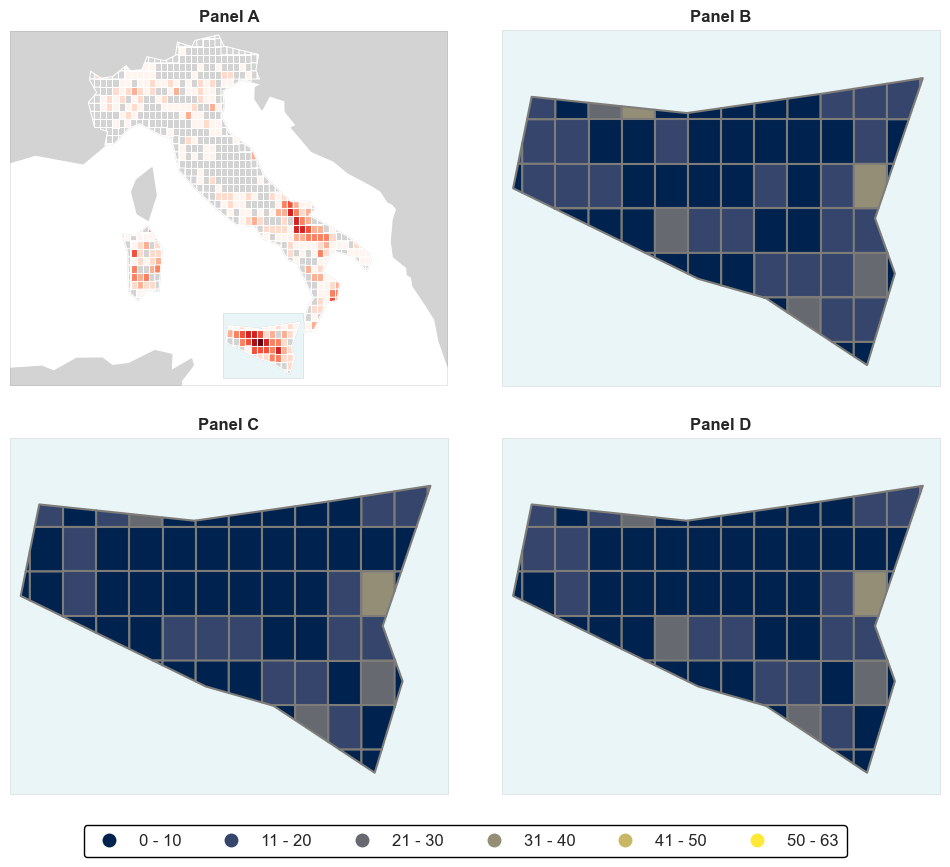

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# https://geopandas.org/en/stable/docs/user_guide/mapping.html
colors = sns.color_palette('cividis', n_colors=1)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

########## Background

polygon = shapely.geometry.box(12.35, 36.5, 15.65, 38.5)
polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon], crs='epsg:4326')
polygon.plot(color='lightblue', ax=axes[0,0], edgecolor='gray', linewidth=0.5, alpha=0.25)
polygon.plot(color='lightblue', ax=axes[0,1], edgecolor='gray', linewidth=0.5, alpha=0.25)
polygon.plot(color='lightblue', ax=axes[1,0], edgecolor='gray', linewidth=0.5, alpha=0.25)
polygon.plot(color='lightblue', ax=axes[1,1], edgecolor='gray', linewidth=0.5, alpha=0.25)

########## Boundary
condition = (world.name == 'Italy')

polygon = world[condition].geometry.unary_union
world_boundary = gpd.GeoDataFrame(geometry=[polygon], crs=world[condition].crs)

########## Ax1 Difference

#condition = (final_gdf_bounded['year'] == 2004) & (final_gdf_bounded['burned_area'] > 0)
#plot_intersection = world.overlay(final_gdf_bounded[condition], how='difference')
#plot_intersection.plot(ax=axes[0,0], color='lightgray', edgecolor='white', linewidth=1.5)

########## Ax1 Intersection

world.plot(color='lightgrey', edgecolor='lightgrey', ax=axes[0,0])

##########

condition = (final_gdf_bounded['year'] == 2004) & (final_gdf_bounded['burned_area'] == 0)
plot_intersection = final_gdf_bounded[condition].overlay(world_boundary, how='intersection')

plot_intersection.plot(column='burned_area', color='lightgray', 
                       legend=False, ax=axes[0,0], edgecolor='white', linewidth=0.75)

########## 

condition = (final_gdf_bounded['year'] == 2004) & (final_gdf_bounded['burned_area'] > 0)
plot_intersection = final_gdf_bounded[condition].overlay(world_boundary, how='intersection')

condition = (plot_intersection.grump_Countryeng == 'Italy')
plot_intersection[condition].plot(column='burned_area', cmap='Reds', scheme='user_defined',# RdYlGn
                       classification_kwds={'bins':[0.2, 0.5, 1, 2, 5, 10, 20]},
                       legend=False, ax=axes[0,0], edgecolor='white', linewidth=0.75)

########## Ax2 Difference

condition = (final_gdf_bounded['year'] == 2002)
plot_intersection = world.overlay(final_gdf_bounded[condition], how='difference')
plot_intersection.plot(ax=axes[0,1], color='lightgray', edgecolor=colors[0], linewidth=1.5)

########## Ax2 Intersection

condition = (final_gdf_bounded['year'] == 2002)
plot_intersection = final_gdf_bounded[condition].overlay(world_boundary, how='intersection')

plot_intersection.plot(column='light', cmap='cividis', scheme='user_defined',# RdYlGn
                       classification_kwds={'bins':[10, 20, 30, 40, 50, 60]},
                       legend=False, ax=axes[0,1], edgecolor=colors[0], linewidth=1.5)

########## Ax3 Difference

condition = (final_gdf_bounded['year'] == 2004)
plot_intersection = world.overlay(final_gdf_bounded[condition], how='difference')
plot_intersection.plot(ax=axes[1,0], color='lightgray', edgecolor=colors[0], linewidth=1.5)

########## Ax3 Intersection

condition = (final_gdf_bounded['year'] == 2004)
plot_intersection = final_gdf_bounded[condition].overlay(world_boundary, how='intersection')

plot_intersection.plot(column='light', cmap='cividis', scheme='user_defined',# RdYlGn
                       classification_kwds={'bins':[10, 20, 30, 40, 50, 60]},
                       legend=True, ax=axes[1,0], edgecolor=colors[0], linewidth=1.5,
                       legend_kwds=dict(loc='lower left', bbox_to_anchor=(0.15,-0.2), 
                          ncol=9, frameon=True,
                          labels=['0 - 10', '11 - 20', '21 - 30', '31 - 40', '41 - 50', '50 - 63'],  
                          prop={"size":12}, facecolor='white', edgecolor='black', borderpad=0.5, 
                          framealpha=1))

########## Ax4 Difference

condition = (final_gdf_bounded['year'] == 2006)
plot_intersection = world.overlay(final_gdf_bounded[condition], how='difference')
plot_intersection.plot(ax=axes[1,1], color='lightgray', edgecolor=colors[0], linewidth=1.5)

########## Ax4 Intersection

condition = (final_gdf_bounded['year'] == 2006)
plot_intersection = final_gdf_bounded[condition].overlay(world_boundary, how='intersection')

plot_intersection.plot(column='light', cmap='cividis', scheme='user_defined',# RdYlGn
                       classification_kwds={'bins':[10, 20, 30, 40, 50, 60]},
                       legend=False, ax=axes[1,1], edgecolor=colors[0], linewidth=1.5)

########## 


condition = (world.name == 'Italy')
xmin, ymin, xmax, ymax = world[condition].total_bounds

axes[0,0].set_ylim(36.25, 47.25)
axes[0,0].set_xlim(3.5, 21.65)

axes[0,1].set_ylim(36.5, 38.5)
axes[0,1].set_xlim(12.35, 15.65)
axes[1,0].set_ylim(36.5, 38.5)
axes[1,0].set_xlim(12.35, 15.65)
axes[1,1].set_ylim(36.5, 38.5)
axes[1,1].set_xlim(12.35, 15.65)

axes[0,0].set_title('Panel A', fontweight='bold')
axes[0,1].set_title('Panel B', fontweight='bold')
axes[1,0].set_title('Panel C', fontweight='bold')
axes[1,1].set_title('Panel D', fontweight='bold')

axes[0,0].set_axis_off()
axes[0,1].set_axis_off()
axes[1,0].set_axis_off()
axes[1,1].set_axis_off()

fig.subplots_adjust(wspace=0.125, hspace=0.125)

polygon = shapely.geometry.box(3.5, 36.3, 21.64, 47.25)
polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon], crs='epsg:4326')
polygon.plot(color='none', ax=axes[0,0], edgecolor='gray', linewidth=0.5, alpha=0.25)

#plt.show()
plt.savefig(
   os.path.join(os.path.dirname("__file__"), '..', 'outputs', 'Light_Sicily_detailed.png'), dpi=(150)
)

---

In [7]:
condition = (final_gdf_bounded['year'] == 2002) & (final_gdf_bounded['light'] > 0)
plot_intersection = final_gdf_bounded[condition].overlay(world_boundary, how='intersection')

condition = (plot_intersection.geometry.bounds.minx < 15.5) & (plot_intersection.geometry.bounds.miny < 38.5) 
condition = condition & (plot_intersection.grump_Countryeng == 'Italy')
plot_intersection[condition].light.describe()

count    61.000000
mean     11.655738
std       7.420434
min       1.000000
25%       8.000000
50%      10.000000
75%      15.000000
max      37.000000
Name: light, dtype: float64

In [8]:
condition = (final_gdf_bounded['year'] == 2004) & (final_gdf_bounded['light'] > 0)
plot_intersection = final_gdf_bounded[condition].overlay(world_boundary, how='intersection')

condition = (plot_intersection.geometry.bounds.minx < 15.5) & (plot_intersection.geometry.bounds.miny < 38.5) 
condition = condition & (plot_intersection.grump_Countryeng == 'Italy')
plot_intersection[condition].light.describe()

# plot_intersection[condition][['grump_NAME' ,'light']].sort_values(by=['light'], ascending=False).head(10)

count    61.000000
mean      9.180328
std       6.589153
min       1.000000
25%       5.000000
50%       8.000000
75%      12.000000
max      34.000000
Name: light, dtype: float64

In [9]:
condition = (final_gdf_bounded['year'] == 2006) & (final_gdf_bounded['light'] > 0)
plot_intersection = final_gdf_bounded[condition].overlay(world_boundary, how='intersection')

condition = (plot_intersection.geometry.bounds.minx < 15.5) & (plot_intersection.geometry.bounds.miny < 38.5) 
condition = condition & (plot_intersection.grump_Countryeng == 'Italy')
plot_intersection[condition].light.describe()

count    60.000000
mean      9.550000
std       6.502737
min       2.000000
25%       6.000000
50%       7.500000
75%      12.000000
max      33.000000
Name: light, dtype: float64

---